## 1. Load kikuchi Dataset

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
%matplotlib inline

import numpy as np
import torch
from orix import io
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from data_prepare import filter_files_by_coordinates, KikuchiDataset, coord_xmap_dict
from vae_cnn import VAE, train_vae
from reconstruct_visualization import reconstruct_and_visualize, latent_space_visualize

In [3]:
# select the Kikuchi Patterns within ROI
selected_files = filter_files_by_coordinates(
    folder_path="../EBSD_scan",
    x_range=(20,50),
    y_range=(5,35)
)
print(f"{len(selected_files)} Figures are selected within the ROI")

961 Figures are selected within the ROI


In [4]:
dataset = KikuchiDataset(selected_files, transform=None)
print(f"The size of the dataset: {len(dataset)}")

The size of the dataset: 961


In [5]:
coord, image= dataset.__getitem__(1)
print(np.shape(image))

[########################################] | 100% Completed | 106.04 ms
Image data range: -1.0 to 1.0
(1, 120, 120)


In [6]:
# obtain the index information (commercial software processed results)
fname_ang = "EBSD_scan/Scan3_cropped.ang"
xmap = io.load(fname_ang)   


# construct a dictionary indexed by coordinates to obtain phase_id information (or others/ orientations?)
coord_index= coord_xmap_dict(xmap)

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


## 2. VAE training

In [7]:
# Hyperparameter setting
latent_dim = 16
batch_size = 32
epochs = 50
learning_rate = 1e-4

In [8]:
# device options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
# --- Model instance ---
model = VAE(latent_dim=latent_dim).to(device)
print("--- Model Architecture (LeakyReLU + Tanh Output) ---")
print(model)
print("----------------------------------------------------")

--- Model Architecture (LeakyReLU + Tanh Output) ---
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(9, 9), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(4, 8, kernel_size=(9, 9), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(16, 32, kernel_size=(8, 8), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_mu): Linear(in_features=32, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
  (fc_decode): Linear(in_features=16, out_features=512, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(9, 9), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(9, 9), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_sl

In [10]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data preparation
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(f"Data loaded: {len(dataset)} images, Batch size: {batch_size}")
print("IMPORTANT: Input data assumed to be normalized to [-1, 1] for Tanh output.")

Data loaded: 961 images, Batch size: 32
IMPORTANT: Input data assumed to be normalized to [-1, 1] for Tanh output.


In [11]:
# VAE model training
train_vae(dataloader, model, device, optimizer, epochs)

Epoch [1/50], Batch [1/31], Loss: 1079.3501, MSE: 1079.2599, KLD: 0.0902
Epoch [1/50], Batch [31/31], Loss: 1023.2151, MSE: 1023.1595, KLD: 0.0557
====> Epoch: 1 Average loss: 1082.9734 (MSE: 1082.9092, KLD: 0.0643)
Epoch [2/50], Batch [1/31], Loss: 1134.4656, MSE: 1134.4073, KLD: 0.0582
Epoch [2/50], Batch [31/31], Loss: 855.6614, MSE: 855.4948, KLD: 0.1667
====> Epoch: 2 Average loss: 1058.1923 (MSE: 1058.0450, KLD: 0.1473)
Epoch [3/50], Batch [1/31], Loss: 1081.7400, MSE: 1081.3141, KLD: 0.4259
Epoch [3/50], Batch [31/31], Loss: 1037.6904, MSE: 1029.1404, KLD: 8.5500
====> Epoch: 3 Average loss: 1016.6132 (MSE: 1013.4983, KLD: 3.1149)
Epoch [4/50], Batch [1/31], Loss: 987.8529, MSE: 978.2431, KLD: 9.6098
Epoch [4/50], Batch [31/31], Loss: 853.2239, MSE: 834.2003, KLD: 19.0236
====> Epoch: 4 Average loss: 941.2403 (MSE: 928.7971, KLD: 12.4432)
Epoch [5/50], Batch [1/31], Loss: 884.8995, MSE: 867.8584, KLD: 17.0411
Epoch [5/50], Batch [31/31], Loss: 893.0825, MSE: 864.4431, KLD: 28.63

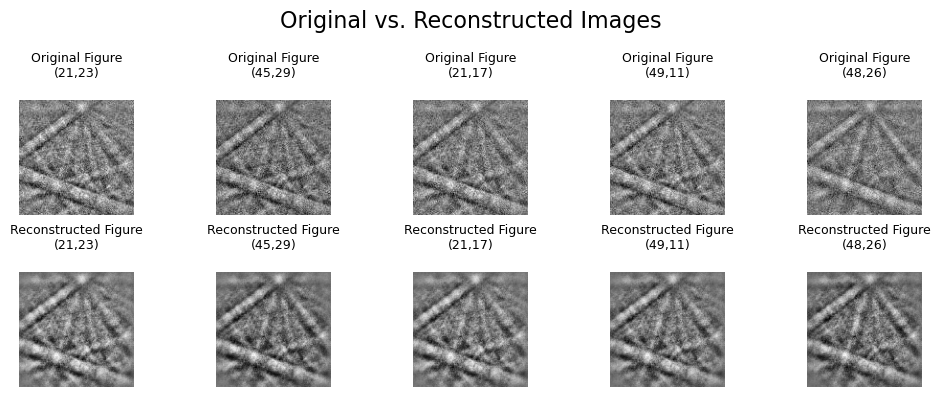

In [12]:
# kikuchi Pattern reconstruction and display part of them
reconstruct_and_visualize(model, device, dataloader, 5)

In [12]:
# obtain the corresponding phase id of each kikuchi pattern
phase_dict = coord_xmap_dict(xmap, 0.05)


--- Visualizing Latent Space (using t-SNE) ---
Generating latent vectors (mu) for visualization (up to 961 points)...
Reached 961 points, stopping latent vector generation.
Collected 961 latent vectors (mu) with dimension 16
Applying t-SNE... (This might take a while for many points)


c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE finished. Reduced shape: (961, 2)


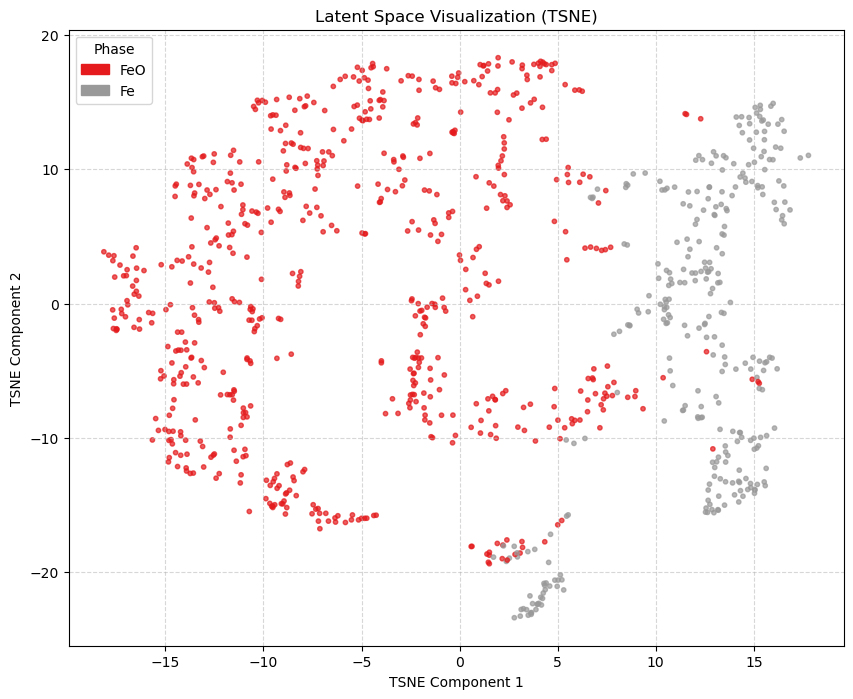

In [14]:
# Latent space decomposition: select n samples for visualization
print("\n--- Visualizing Latent Space (using t-SNE) ---")
latent_space_visualize(model, dataloader, device, phase_dict, method='tsne', max_points=961) # Increase batches for better viz


--- Visualizing Latent Space (using PCA) ---
Generating latent vectors (mu) for visualization (up to 961 points)...
Reached 961 points, stopping latent vector generation.
Collected 961 latent vectors (mu) with dimension 16
PCA finished. Reduced shape: (961, 2)


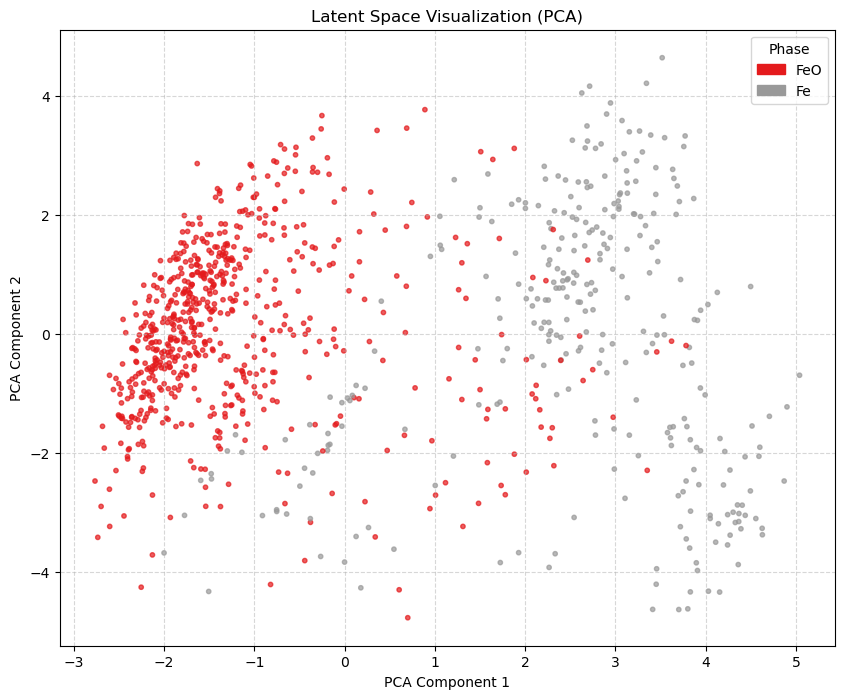

In [15]:
# Latent space decomposition: select n samples for visualization
print("\n--- Visualizing Latent Space (using PCA) ---")
latent_space_visualize(model, dataloader, device,phase_dict, method='pca', max_points=961) # Increase batches for better viz


--- Visualizing Latent Space (using cNMF) ---
Generating latent vectors (mu) for visualization (up to 961 points)...
Reached 961 points, stopping latent vector generation.
Collected 961 latent vectors (mu) with dimension 16


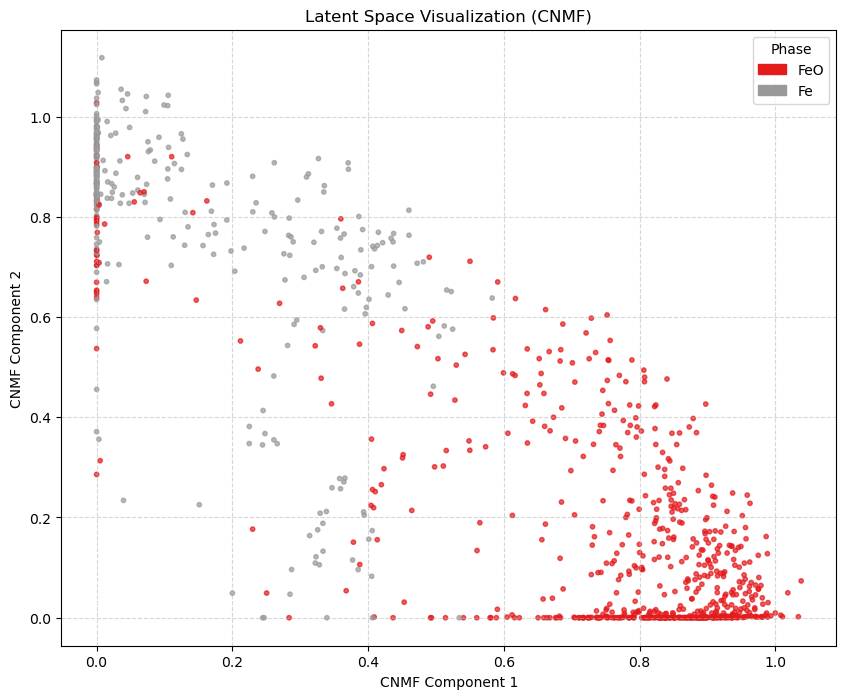

: 

In [ ]:
# Latent space decomposition: select n samples for visualization
print("\n--- Visualizing Latent Space (using cNMF) ---")
latent_space_visualize(model, dataloader, device, phase_dict, method='cnmf', max_points=961, components_coords=[(40, 27), (44, 12)]) # Increase batches for better viz